# Binarization

## 0. Import package

In [1]:
%matplotlib inline

import cv2
import collections

import openalea.phenomenal.image as phm_img
import openalea.phenomenal.data as phm_data
import openalea.phenomenal.display as phm_display
from openalea.phenotyping_data.fetch import fetch_all_data

## 1. Prerequisites

### 1. Load images

Here, we load all the image of the dataset to simply the toturial, commodly you load just the images you want process one after the other.

In [12]:
data_dir = fetch_all_data("plant_6/raw").parent
raw_images = phm_data.raw_images(data_dir)

### 1.3. Display images 

You can view each image according to this date and angle of view like this :
Note : Angle top view is represented by negative number (-1)

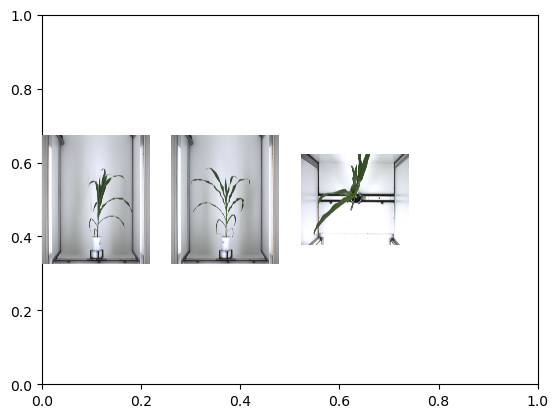

In [6]:
phm_display.show_images(
    [raw_images["side"][120], raw_images["side"][30], raw_images["top"][0]]
)

## 2. Binarization

### 2.1. Define a binarization routines

In [13]:
masks=fetch_all_data("plant_6/mask")

In [14]:
def routine_side_binarization(image, mean_img):
    maks = phm_data.tutorial_data_binarization_mask(data_dir)

    threshold = 0.3
    dark_background = False

    hsv_min = (30, 11, 0)
    hsv_max = (129, 254, 141)

    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Threshold the image with HSV min and max value
    binary_hsv_image = phm_img.threshold_hsv(hsv_image, hsv_min, hsv_max, maks[0])

    # Threshold the image with difference between image and mean_image
    binary_mean_shift_image = phm_img.threshold_meanshift(
        image, mean_img, threshold, dark_background, maks[1]
    )

    # Add the two image
    result = cv2.add(binary_hsv_image, binary_mean_shift_image)

    # Erode and dilate the image to remove possible noise
    result = cv2.medianBlur(result, 3)

    return result


def routine_top_binarization(image):
    hsv_min = (42, 75, 28)
    hsv_max = (80, 250, 134)
    median_blur_size = 9
    iterations = 5

    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Apply a median blur on the image
    hsv_image = cv2.medianBlur(hsv_image, ksize=median_blur_size)

    # Threshold the image with HSV min and max value
    bin_img = phm_img.threshold_hsv(hsv_image, hsv_min, hsv_max)
    # dilate and erode the image to remove possible noise
    bin_img = phm_img.dilate_erode(bin_img, kernel_shape=(3, 3), iterations=iterations)

    return bin_img

### 2.2. Binarize images

In [15]:
# Compute the mean image of the side view image

mean_img = phm_img.mean_image(list(raw_images["side"].values()))

routine_binarization = {
    "side": lambda im: routine_side_binarization(im, mean_img),
    "top": lambda im: routine_top_binarization(im),
}

bin_images = collections.defaultdict(dict)
for id_camera in raw_images:
    for angle in raw_images[id_camera]:
        bin_images[id_camera][angle] = routine_binarization[id_camera](
            raw_images[id_camera][angle]
        )

### 2.3. Display images binarize 

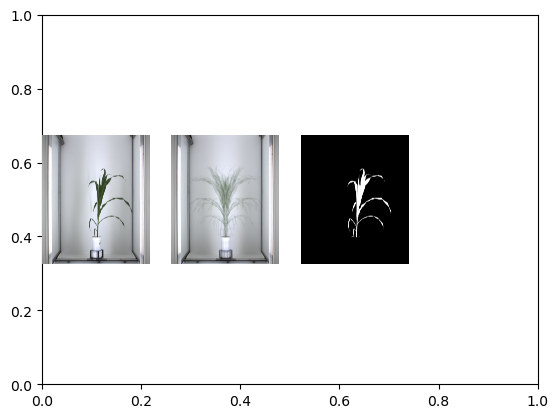

In [16]:
id_camera, angle = "side", 120
phm_display.show_images(
    [raw_images[id_camera][angle], mean_img, bin_images[id_camera][angle]]
)

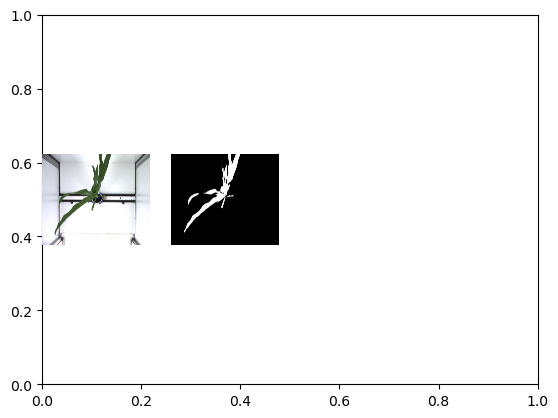

In [17]:
id_camera, angle = "top", 0
phm_display.show_images([raw_images[id_camera][angle], bin_images[id_camera][angle]])